In [ ]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [ ]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.5.1+cpu; Torch-cuda version: None; Torch Geometric version: 2.6.1.


In [ ]:
# Define the main directory
MAIN_DIR = r"D:\CPEN355"  # Use raw string to handle backslashes correctly

# Define the data directory
DATA_DIR = r"D:\CPEN355\HalfMil\FirstHalfData"  # Correct the path and use a raw string

# Change the current working directory to MAIN_DIR
os.chdir(MAIN_DIR)

In [ ]:
# Citation reminder
# TODO: create a method that returns the node info for networkx node generation
import networkx as nx

class Artist:
  """
  Class for artist, containing attributes:
    1. Artist_name
    2. Artist_URI
  """
  def __init__(self, track_dict):
    self.artist_name = track_dict["artist_name"]
    self.artist_uri = track_dict["artist_uri"]
    # Maybe we should include albums too...

  def __str__(self):
    return f"Artist {self.artist_name} with URI {self.artist_uri}"

  def node_info(self):
    return {"artist_name": self.artist_name, "node_type": "artist"}

class Album:
  """
  Class for album, containing attributes:
    1. Album_name
    2. Album_URI
  """
  def __init__(self, track_dict):
    self.album_name = track_dict["album_name"]
    self.album_uri = track_dict["album_uri"]

  def __str__(self):
    return f"Album {self.name} with URI {self.uri}"

  def node_info(self):
    return {"album_name": self.album_name, "node_type": "album"}

class Track:
  """
  Class for a track, containing its attributes:
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """

  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.duration_ms = track_dict["duration_ms"]
    self.album = Album(track_dict)
    self.artist = Artist(track_dict)
    self.playlist = playlist

  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist.artist_name} ({self.artist.artist_name}) in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"

  def node_info(self):
    return {"track_name": self.name, "duration_ms": self.duration_ms, "node_type": "track"}

class Playlist:
  """
  Class for a playlist, containing its attributes:
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):
    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data
    self.num_albums = json_data["num_albums"]
    self.tracks = {}

# Loads all of tracks in json data for playlist
  def load_tracks(self):
    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"

  def node_info(self):
    node_info = {x: self.data[x] for x in self.data if x in ["name", "num_tracks", "num_albums", "duration_ms", "num_artists"]}
    node_info["node_type"] = "playlist"
    return node_info


class JSONFile:
  """
  Class for a JSON file, containing its attributes:
    1. File Name
    2. Index to begin numbering playlists at
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(os.path.join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

# Load all of playlists in json data
  def process_file(self):
    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name


class DataSet:
  """
  Class for the Spotify data, containing its attributes:
    1. JSON File List
    2. Dictionary of JSON files (file_name : JSONFile), populated by .process_files()
    3. Number of files to keep
  """

  def __init__(self, data_path, num_files_to_keep):
    self.data_path = data_path
    self.num_files_to_keep = num_files_to_keep
    self.json_files = self.retrieve_files()
    self.files = {}

# Retrieve all json files from the dataset
  def retrieve_files(self):
    json_files = sorted(
      [file for file in os.listdir(self.data_path) if file.endswith('.json')],
      key=lambda f: int(''.join(filter(str.isdigit, f))) if any(char.isdigit() for char in f) else float('inf')
    )[:self.num_files_to_keep]
    return json_files

# Load all of the files in dataset
  def process_files(self):
    for i, file in enumerate(self.json_files):
      json_file = JSONFile(self.data_path, file, i*1000)
      json_file.process_file()
      self.files[json_file.file_name] = json_file
      print(f"Reading: {file}")

  def __str__(self):
    return f"DataSet with {len(self.files)} JSON files loaded."

In [ ]:
# Modified NX Graph Generation

import networkx as nx
from sklearn.preprocessing import LabelEncoder

class NXPlaylistGraph:
  """
  Class for a playlist graph, containing its attributes:
    1. NX Graph of playlists, songs, artists and albums, populated by .generate_graph()
    2. Number of files to keep
    3. Data Set
    4. kcore to be used in nx.k_core
  """

  def __init__(self, data_dir, num_files_to_keep, kcore):
    self.num_files_to_keep = num_files_to_keep
    self.kcore = kcore
    self.data_set = DataSet(data_dir, self.num_files_to_keep)
    self.data_set.process_files()
    self.nx_graph = nx.Graph()

# Generate a networkx graph from the playlist data
  def generate_graph(self):
    for file_name, json_file in self.data_set.files.items():
      print(f"Processing file: {file_name}")

      for playlist_name, playlist in json_file.playlists.items():
        self.nx_graph.add_node(playlist_name, type="playlist", name=playlist.title)


        for track_uri, track in playlist.tracks.items():
          self.nx_graph.add_node(track.uri, type="track", name=track.name)
          self.nx_graph.add_edge(track_uri, playlist_name, edge_type="track_to_playlist")

          # self.nx_graph.add_node(track.album.album_uri, type="album", name=track.album.album_name)
          # self.nx_graph.add_edge(track.album.album_uri, track_uri, edge_type="album_to_track")
          # self.nx_graph.add_edge(track.album.album_uri, playlist_name, edge_type="album_to_playlist")

          # self.nx_graph.add_node(track.artist.artist_uri, type="artist", name=track.artist.artist_name)
          # self.nx_graph.add_edge(track.artist.artist_uri, track_uri, edge_type="artist_to_track") # Might not be necessary
          # self.nx_graph.add_edge(playlist_name, track.artist.artist_uri, edge_type="playlist_to_artist")
          # self.nx_graph.add_edge(track.artist.artist_uri, track.album.album_uri, edge_type="artist_to_album")

    print(self.nx_graph)

    self.nx_graph = nx.k_core(self.nx_graph, k=self.kcore)

    print(self.nx_graph)

  def get_graph(self):
    return self.nx_graph

In [ ]:
# in thousands remember? files as in actual files
NUM_FILES_TO_KEEP = 400
KCORE = 10
playlist_G_NX = NXPlaylistGraph(DATA_DIR, NUM_FILES_TO_KEEP, KCORE)
playlist_G_NX.generate_graph()
# playlist_G_NX.encode_graph()

Reading: mpd.slice.0-999.json
Reading: mpd.slice.1000-1999.json
Reading: mpd.slice.2000-2999.json
Reading: mpd.slice.3000-3999.json
Reading: mpd.slice.4000-4999.json
Reading: mpd.slice.5000-5999.json
Reading: mpd.slice.6000-6999.json
Reading: mpd.slice.7000-7999.json
Reading: mpd.slice.8000-8999.json
Reading: mpd.slice.9000-9999.json
Reading: mpd.slice.10000-10999.json
Reading: mpd.slice.11000-11999.json
Reading: mpd.slice.12000-12999.json
Reading: mpd.slice.13000-13999.json
Reading: mpd.slice.14000-14999.json
Reading: mpd.slice.15000-15999.json
Reading: mpd.slice.16000-16999.json
Reading: mpd.slice.17000-17999.json
Reading: mpd.slice.18000-18999.json
Reading: mpd.slice.19000-19999.json
Reading: mpd.slice.20000-20999.json
Reading: mpd.slice.21000-21999.json
Reading: mpd.slice.22000-22999.json
Reading: mpd.slice.23000-23999.json
Reading: mpd.slice.24000-24999.json
Reading: mpd.slice.25000-25999.json
Reading: mpd.slice.26000-26999.json
Reading: mpd.slice.27000-27999.json
Reading: mpd.sli

In [ ]:
G_NX = playlist_G_NX.get_graph()
print('Num nodes:', G_NX.number_of_nodes(), '. Num edges:', G_NX.number_of_edges())

Num nodes: 570402 . Num edges: 23427997


In [ ]:
import re

# Since we have different node types with mix namings (letters + numbers)
# Help sorting the nodes with priority + numerical order
def custom_node_sort(node):
  """
  Custom sorting function to handle 4 node types and numerical sorting:
  1. playlist
  2. album
  3. artist
  4. track
  """
  node_type = G_NX.nodes[node]['type']
  type_priority = {
      'playlist': 1,
      'track': 2
  }

  # Extract numerical part using regular expression
  numerical_part = int(re.findall(r'\d+', node)[0]) if re.findall(r'\d+', node) else 0

  return (type_priority[node_type], numerical_part, node)  # Sort by type, numerical part, then node name

In [ ]:
n_nodes, n_edges = G_NX.number_of_nodes(), G_NX.number_of_edges()
print(n_nodes)
print(n_edges)
# Sort nodes inside the initial graph, currently in order of playlist, album, artist, track, and with numerical portion ordered in numerical order
sorted_nodes = sorted(list(G_NX.nodes()), key=custom_node_sort)

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
# node2id maps/labels each node with indices from 0 to # of nodes - 1
# id2node maps/labels back each node index to correlated node types
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

# a relabeled graph with each node type replaced with assigned indices
G_NX_sorted = nx.relabel_nodes(G_NX, node2id)

# sort indices by the origianl node type
playlists_idx = [i for i, v in enumerate(node2id.keys()) if "playlist" in v]
tracks_idx = [i for i, v in enumerate(node2id.keys()) if "track" in v]
# artists_idx = [i for i, v in enumerate(node2id.keys()) if "artist" in v]
# albums_idx = [i for i, v in enumerate(node2id.keys()) if "album" in v]

n_playlists = len(playlists_idx)
n_tracks = len(tracks_idx)
# n_artists = len(artists_idx)
# n_albums = len(albums_idx)


570402
23427997


In [ ]:
# Now prepare message passsing edges + supervision edges, and
# Map the networkx graph to pytorch geometric Data object
num_nodes = n_playlists + n_tracks
edge_idx = torch.Tensor(np.array(G_NX_sorted.edges()).T)
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)
print("Edge index shape:", edge_idx.shape)
print(edge_idx[1])

# Dictionary to access different edges by types
# Note that edges are stored as indicies in the format of (source,destination)
# Use id2node to map it back to exact nodes
edge_list = {
  'artist_to_album': [],
  'album_to_track': [],
  'track_to_playlist': [],
  'artist_to_track': [],
  'album_to_playlist': [],
  'playlist_to_artist': [],
}

for source, dest, data in G_NX_sorted.edges(data=True):
    edge_list[data['edge_type']].append((source, dest))

# Use RandomLinkSplit to randomly remove the x% of edges from graph
# Ensures no duplicate edges between datasets
transform_split = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.2, num_test=0.1
)

train_split, val_split, test_split = transform_split(graph_data)

Edge index shape: torch.Size([2, 23427997])
tensor([423918., 462226., 395689.,  ..., 248481., 459215., 531213.])


In [ ]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64) # Contains message passing edge indicies for training
val_split.edge_index = val_split.edge_index.type(torch.int64) # Contains message passing edge indicies for validation
test_split.edge_index = test_split.edge_index.type(torch.int64) # Contains message passing edge indicies for testing

# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64) # Contains supervision edge indicies for training
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64) # Contains supervision edge indicies for validation
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64) # Contains supervision edge indicies for testing

print(f"Train set has {train_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 8178565 positive supervision edges
Validation set has 2336732 positive supervision edges
Test set has 1168366 positive supervision edges
Train set has 16357130 message passing edges
Validation set has 16357130 message passing edges
Test set has 21030594 message passing edges


In [ ]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In [ ]:
def precision_at_k(data, model, k=300, batch_size=64, device=None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Precision at k for the batch is number of relevant items in top k divided by k
        precision = hits / k
        relevant_counts_list.append(precision)

    # Compute average precision@k
    precision_at_k = torch.cat(relevant_counts_list, dim=0)
    precision_at_k = torch.mean(precision_at_k)

    if precision_at_k.numel() == 1:
        return precision_at_k.item()
    else:
        raise ValueError("precision_at_k contains more than one item.")


In [ ]:

class GCN(torch.nn.Module):

    def __init__(self, num_nodes: int, embedding_dim: int, num_layers: int, alpha: Optional[Union[float, Tensor]] = None,
        conv_layer = "LGC", name = None, **kwargs,):
        super().__init__()
        self.sigmoid = torch.sigmoid
        self.conv_layer = conv_layer
        self.name = f"{self.conv_layer}_RUN5"
        alpha_string = "alpha"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.alpha_vals = torch.rand(num_layers+1)
        alpha = nn.Parameter(self.alpha_vals/torch.sum(self.alpha_vals))


        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers
        if conv_layer == "LGC":
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads
          n_heads = 3
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])
        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, edge_index: Adj, edge_label_index: OptTensor = None) -> Tensor:
        # Default edge_label_index to edge_index if not provided
        edge_label_index = edge_label_index or (torch.stack(edge_index.coo()[:2], dim=0) if isinstance(edge_index, SparseTensor) else edge_index)
        out = self.get_embedding(edge_index)
        return self.predict_link(out, edge_label_index)

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight
        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
                out = out + self.linears[i](x) * weights[i + 1]
        return out

    def predict_link(self, embed: Adj, edge_label_index: Adj) -> Tensor:
        return (embed[edge_label_index[0]] * embed[edge_label_index[1]]).sum(dim=-1)

    def bpr_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        """
        Compute the mean Bayesian Personalized Ranking (BPR) loss with optional L2 regularization.

        Args:
            pos_edge_rank (Tensor): Scores for positive edge pairs.
            neg_edge_rank (Tensor): Scores for negative edge pairs.
            lambda_reg (float): Regularization strength for L2 regularization (default: 1e-4).

        Returns:
            Tensor: The computed BPR loss.
        """
        # Compute the pairwise differences between positive and negative rankings
        differences = pos_edge_rank - neg_edge_rank
        # Compute the BPR loss: log-sigmoid of the differences
        loss = -torch.log(torch.sigmoid(differences)).mean()
        return loss


In [ ]:
def sample_negative_edges(data, num_playlists, num_tracks):
    playlists = data.edge_label_index[0, :]  # Source nodes (playlists)
    tracks = torch.randint(
        num_playlists,
        num_playlists + num_tracks - 1,
        size=data.edge_label_index[1, :].size()
    )  # Random track indices

    # Stack the playlists and tracks to form negative edge indices
    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1])  # All-zero labels for negative edges

    return neg_edge_index, neg_edge_label


def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:num_playlists].to(device)
        tracks_embeddings = embeddings[num_playlists:].to(device)

    positive_playlists, positive_tracks = data.edge_label_index
    num_edges = positive_playlists.size(0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    positive_mask[positive_playlists, positive_tracks - num_playlists] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            playlists_embeddings[positive_playlists[batch_start:batch_end]], tracks_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_playlists[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_playlists

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_playlists[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label


In [ ]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc

In [ ]:
# Train
def train(datasets, model, optimizer, args):
  print(f"Beginning training")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'precision': [],
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()

    neg_edge_index, neg_edge_label = sample_negative_edges(train_data, n_playlists, n_tracks)

    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link(embed, train_data.edge_label_index)
    neg_scores = model.predict_link(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    loss = model.bpr_loss(pos_scores, neg_scores, lambda_reg = 0)

    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(model, val_data, epoch, val_neg_edge, val_neg_label)

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0:
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])
      val_precision = precision_at_k(val_data, model, k = 300, device = args["device"])
      print(f"Val recall {val_recall}")
      print(f"Precision recall {val_precision}")
      stats['val']['recall'].append(val_recall)
      stats['val']['precision'].append(val_precision)

    if epoch % 20 == 0:
      path = os.path.join("model_embeddings", f"{model.conv_layer}_RUN5")
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", f"{model.conv_layer}_RUN5.pt"))

  pickle.dump(stats, open(f"model_stats/{model.conv_layer}_RUN5.pkl", "wb"))
  return stats

def test(model, data, epoch = 0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM

    # conduct negative sampling
    neg_edge_index, neg_edge_label = sample_negative_edges(data, n_playlists, n_tracks)
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding
    pos_scores = model.predict_link(embed, data.edge_label_index)
    neg_scores = model.predict_link(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss
    loss = model.bpr_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)

  return loss, roc, neg_edge_index, neg_edge_label

In [ ]:
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [ ]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 32,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 100
}

In [ ]:
num_nodes = n_playlists + n_tracks
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "LGC"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
# send data, model to GPU if available
playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(args["device"])
tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(args["device"])
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(
  (embedding): Embedding(570402, 32)
  (convs): ModuleList(
    (0-2): 3 x LGConv()
  )
)

In [ ]:
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [ ]:
train(datasets, model, optimizer, args)

Beginning training
Epoch 0; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.5000410526797249; Val ROC 0.5001638376802623
Val recall 0.13609260320663452
Precision recall 3.1451432732865214e-05
Epoch 1; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.4993342313961204; Val ROC 0.4994723899344939
Epoch 2; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.5001680541662287; Val ROC 0.5004098472102604
Epoch 3; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.4986793680108323; Val ROC 0.5002261462992315
Epoch 4; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.49905440908058807; Val ROC 0.49997373700067016
Epoch 5; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.4997986302798773; Val ROC 0.49990620406662445
Epoch 6; Train loss 0.6931471228599548; Val loss 0.6931471824645996; Train ROC 0.4995683701058386; Val ROC 0.500327197657991
Epoch 7; Train loss 0.6931

{'train': {'loss': [tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackward0>),
   tensor(0.6931, grad_fn=<NegBackwar

In [ ]:
test(model, datasets['test'])

(tensor(0.6931),
 np.float64(0.5003972918357218),
 tensor([[ 34388, 297775, 358124,  ...,  93364, 348922, 182526],
         [387086, 437016, 379331,  ..., 397298, 404122, 407661]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [ ]:
model2 = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "LGC"
)
train(datasets, model2, optimizer, args)
test(model2, datasets['test'])

Beginning training
Epoch 0; Train loss 0.6931471824645996; Val loss 0.6931472420692444; Train ROC 0.49957943426104445; Val ROC 0.5001666637654862
Val recall 0.13975803554058075
Precision recall 5.032699118601158e-05
Epoch 1; Train loss 0.6931473016738892; Val loss 0.6931472420692444; Train ROC 0.49993227056143147; Val ROC 0.4999376222242458
Epoch 2; Train loss 0.6931473016738892; Val loss 0.6931472420692444; Train ROC 0.4997003067892545; Val ROC 0.5003021064833647
Epoch 3; Train loss 0.6931471824645996; Val loss 0.6931472420692444; Train ROC 0.4997446046995841; Val ROC 0.500434413562972
Epoch 4; Train loss 0.6931473016738892; Val loss 0.6931472420692444; Train ROC 0.4998322381733959; Val ROC 0.5002221915701812
Epoch 5; Train loss 0.6931471824645996; Val loss 0.6931472420692444; Train ROC 0.49967846961772727; Val ROC 0.5000080551701347
Epoch 6; Train loss 0.6931473016738892; Val loss 0.6931472420692444; Train ROC 0.4998306081413386; Val ROC 0.4994999756649391
Epoch 7; Train loss 0.69314

(tensor(0.6931),
 np.float64(0.5002370256602939),
 tensor([[ 46588, 139090, 134460,  ..., 169835,  10761, 176501],
         [215321, 190636, 203650,  ..., 233667, 249381, 285154]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [ ]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)

file_path = r"D:\CPEN355\model_stats\LGC_RUN5.pkl"
print("File exists:", os.path.exists(file_path))


Current working directory: D:\CPEN355
File exists: True


In [ ]:

lgc_stats = pickle.load(open(r"D:\CPEN355\model_stats\LGC_RUN5.pkl", "rb"))
lgc_stats_hard = pickle.load(open(r"D:\CPEN355\model_stats\LGC_RUN6.pkl", "rb"))
gat_stats = pickle.load(open(r"D:\CPEN355\model_stats\GAT_RUN5.pkl", "rb"))
gat_stats_hard = pickle.load(open(r"D:\CPEN355\model_stats\GAT_RUN6.pkl", "rb"))
sage_stats = pickle.load(open(r"D:\CPEN355\model_stats\SAGE_RUN5.pkl", "rb"))
sage_stats_hard = pickle.load(open(r"D:\CPEN355\model_stats\SAGE_RUN6.pkl", "rb"))

In [ ]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

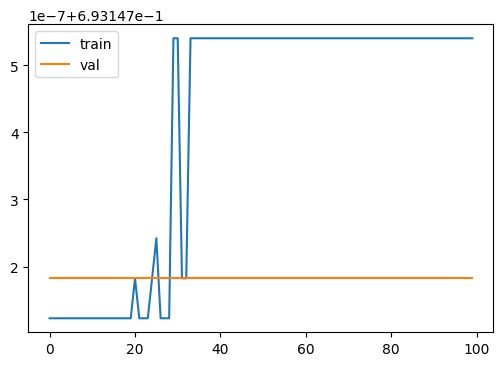

In [ ]:
plot_train_val_loss(lgc_stats)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
lgc_hard_loss = pd.Series(detach_loss(lgc_stats_hard["val"][key])).rolling(3).mean()
gat_hard_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()
sage_hard_loss = pd.Series(detach_loss(sage_stats_hard["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_loss, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_loss, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_loss, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower left')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
lgc_recall = lgc_stats["val"][key]
gat_recall = gat_stats["val"][key]
sage_recall = sage_stats["val"][key]
lgc_hard_recall = lgc_stats_hard["val"][key]
gat_hard_recall = gat_stats_hard["val"][key]
sage_hard_recall = sage_stats_hard["val"][key]
# increment by 10
idx = np.arange(0, 10 * len(lgc_recall), 10)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_recall, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_recall, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_recall, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_recall, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_recall, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_recall, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@300")
ax.set_title("Model Recall@300, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()